# 0. Intro
WeRateDogs is a Twitter account that posts and rates pictures of dogs. These ratings often are not serious and have numerators that are greater than the denominators. 

In the analysis, I will aim to (1) wrangle the data + (2) answer the following questions:

1. What is WeRateDogs's posting trend by month?
2. What is the monthly trend of interactions with WeRateDogs's posts?
3. What are the most popular dog breeds based on number of posts, interactions by Twitter users, and ratings?
4. Is there any correlation between WeRateDogs's ratings and the interactions by Twitter users?

In [2323]:
!pip install seaborn
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2324]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os 
import json 
import re
from scipy.stats import pearsonr
%matplotlib inline
pd.set_option('display.max_colwidth', None)

# 1. Gathering Data

In [2325]:
#1.  Archive file
archive = pd.read_csv('/Users/timtism/Documents/Github Repo/Data Analytics Portfolio/Python/Projects/Twitter WeRateDogs Data Set/datasets/twitter-archive-enhanced.csv')
#2. Image prediction file (URL)
    # Predictions of dog breeds
url_image_predictions = ('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/'
                         '599fd2ad_image-predictions/image-predictions.tsv')

    # Create dataframe from TSV
predictions = pd.read_csv(url_image_predictions, delimiter='\t')

#3. Tweets
tweet = pd.read_json('/Users/timtism/Documents/Github Repo/Data Analytics Portfolio/Python/Projects/Twitter WeRateDogs Data Set/datasets/tweet-json.txt',  lines = True)

---

# 2. Assessing  Data

### a. `archive`

In [2326]:
archive.info()
archive.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1059,741743634094141440,NaN,NaN,2016-06-11 21:27:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Aqua. She's a sandy pupper. Not sure how she feels about being so sandy. Radical tongue slip. 11/10 petable af https://t.co/rYxJ0UQtbE,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/741743634094141440/photo/1,https://twitter.com/dog_rates/status/741743634094141440/photo/1,https://twitter.com/dog_rates/status/741743634094141440/photo/1",11,10,Aqua,NaN,NaN,pupper,NaN
1354,703631701117943808,NaN,NaN,2016-02-27 17:24:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bella. Based on this picture she's at least 8ft tall (wow)! Must be rare. 11/10 would pet on tippy toes https://t.co/XTVbSRdvcp,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1",11,10,Bella,NaN,NaN,NaN,NaN
1317,706593038911545345,NaN,NaN,2016-03-06 21:31:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a sneak peek of me on spring break. 10/10 so many tired pups these days https://t.co/6aJrjKfNqX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706593038911545345/photo/1,10,10,NaN,NaN,NaN,NaN,NaN
1537,689877686181715968,NaN,NaN,2016-01-20 18:30:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Durg. He's trying to conquer his fear of trampolines. 9/10 it's not working https://t.co/5iH08ltkoe,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689877686181715968/photo/1,9,10,Durg,NaN,NaN,NaN,NaN
2205,668633411083464705,NaN,NaN,2015-11-23 03:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Churlie. He likes bagels. 10/10 https://t.co/k8P6FZlzAG,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/668633411083464705/photo/1,https://twitter.com/dog_rates/status/668633411083464705/photo/1",10,10,Churlie,NaN,NaN,NaN,NaN


`archive` columns:
-  `tweet_id`: unique identifier for each tweet
- `in_reply_to_status_id`: original tweet_id if the row is a **reply**. If not, null
- `in_reply_to_user_id`: user id of the original tweet if the row  is a **reply**.  If not, null
- `timestamp`: time when this tweet was created
- `source`: HTML-formatted string of platform to post the tweet
-  `text`: content of the tweet
- `retweeted_status_id`: original tweet_id if the row is a **retweet**. If not, null
- `retweeted_status_user_id`: user id of the original tweet if the row is a **retweet**.  If not, null
- `expanded_urls`: tweet url
- `rating_numerator`: numerator of the rating of the dog. Note: ratings almost always greater than 10
- `rating_denominator`: denominator of the rating of the dog. Note: ratings always have a denominator of 10
- `name`: dog names
- `doggo` / `floofer` / `pupper` / `puppo`: one of the 4 dog stages

In [2327]:
# From .info(), there are 181 retweets records (not null obs in retweeted_status_id)

# Check if there are any records in `archive` whose corresponding record with same tweet_id is missing in `predictions`
len(archive[~archive['tweet_id'].isin(predictions['tweet_id'])])

281

In [2328]:
# Check the `rating_denominator` values:
archive['rating_denominator'].value_counts().sort_index()

rating_denominator
0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: count, dtype: int64

In [2329]:
# Check the `rating_numerator` values:
archive['rating_numerator'].value_counts().sort_index()

rating_numerator
0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: count, dtype: int64

In [2330]:
# Check dog name
archive['name'].value_counts().sort_index(ascending=False)

name
very            5
unacceptable    1
this            1
the             8
such            1
               ..
Aiden           1
Adele           1
Acro            1
Ace             1
Abby            2
Name: count, Length: 956, dtype: int64

In [2331]:
archive['puppo'].value_counts()

puppo
puppo    30
Name: count, dtype: int64

In [2332]:
# Create a column named `counter` that counts the number of dog stages each observation has

dog_stage = ['doggo','floofer','pupper','puppo']
archive['counter'] = 0

archive['counter'] += archive.apply(lambda row: sum(1 for col in dog_stage if not pd.isna(row[col])), axis = 1)

archive.head()



,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,counter
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,NaN,0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,NaN,0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,NaN,0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,NaN,0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,NaN,0


In [2333]:
# Check how many dogs have multiple dog stages
archive['counter'].value_counts() #-> 14 dogs

counter
0    1976
1     366
2      14
Name: count, dtype: int64

### b. `predictions`

In [2334]:
predictions.info()
predictions.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
493,675707330206547968,https://pbs.twimg.com/media/CWCYOqWUAAARmGr.jpg,1,bath_towel,0.721933,False,Staffordshire_bullterrier,0.059344,True,bagel,0.035702,False
1414,771014301343748096,https://pbs.twimg.com/media/CrMxZzgWIAQUxzx.jpg,1,meerkat,0.202335,False,doormat,0.111790,False,macaque,0.088925,False
68,667182792070062081,https://pbs.twimg.com/media/CUJPNjOWsAAZRqP.jpg,1,golden_retriever,0.949892,True,Irish_setter,0.010564,True,Chesapeake_Bay_retriever,0.005821,True
2004,877316821321428993,https://pbs.twimg.com/media/DCza_vtXkAQXGpC.jpg,1,Saluki,0.509967,True,Italian_greyhound,0.090497,True,golden_retriever,0.079406,True
1181,738184450748633089,https://pbs.twimg.com/media/Cj6O1G9UYAAIU-1.jpg,1,Bedlington_terrier,0.289471,True,standard_poodle,0.173685,True,Great_Pyrenees,0.157081,True


`predictions` columns:
- `tweet_id`: mentioned before
- `jpg_url`: dogs' image url
- `img_num`: the image number that corresponded to the most confident prediction (1 to 4, since tweets can have up to 4  images)
- `p1` / `p2` / `p3`: result of dogs that the #x (pX) algorithm to predict the image in the tweet
- `p1_conf` / `p2_conf` / `p3_conf`: how confident the algorithm is in its pX predictions
- `p1_dog` / `p2_dog` / `p3_dog`: whether or not the #x prediction is that breed of dog

In [2335]:
# Check if there's any duplicated rows
print(sum(predictions.duplicated()))

# Check if there's any duplicated `tweet_id`
print(sum(predictions.duplicated('tweet_id')))

# Count number of duplicated `jpg_url` in predictions. (return True -> = 1, False = 0)
print(sum(predictions.duplicated('jpg_url')))

0
0
66


In [2336]:
# Check if duplications are related to retweet?
sum(archive[archive['tweet_id'].isin(predictions[predictions.duplicated('jpg_url')]['tweet_id'])]['retweeted_status_id'].isna())
#  -> all duplicated records have values in retweets (not null) => the duplications are indeed retweets


0

In [2337]:
# Check if the value in `px_conf` is <= 1?
sum(
    (predictions['p1_conf'] >1) |
    (predictions['p2_conf'] >1) |
    (predictions['p3_conf'] >1)
    )
# => No -> reasonable

0

### c. `tweet`

In [2338]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [2401]:
tweet.sample(1)

,tweet_id,retweet_count,favorite_count,display_text_range
2122,670374371102445568,295,785,"[0, 140]"


In [2340]:
# Change name for better mapping later
new_column_names = {
    'id': 'tweet_id'
}

tweet.rename(columns=new_column_names, inplace = True)
# Minimize the dataset
tweet = tweet[['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range']]

`tweet` columns:
- `tweet_id`: as mentioned
- `retweet_count`: number of times this tweet has been retweeted
- `favourite_count`: how many times this tweet has been liked by twitter users
- `display_text_range`: an array of 2 unicode code point, identifying the inclusive start and exclusive end of the displayable content of the tweet

### About the quality
`archive`:
- contains retweets. We only care about unique posts -> this might be considered duplication
- 281 records of tweet_id missing in `predictions`
- error datatypes: `in_reply_to_status_id`,`in_reply_to_user_id`,`timestamp`
- unnecessary html tags in `source` to differentiate utility name
-  `rating_numerator` has values <10 as well as some very large numbers
- `rating_denominator` has values other than 10
- wrong dog names starting with lowercase characters and glibberish (eg: a,an,actually,by)
- some records have more than one dog stages

`predictions`:
- After tidying, prediction number needs to have int type
- Value in `px` are inconsistent in the first letter capitalization
- Not all have dog-related prediction -> need to be dropped
- Duplicated `jpg_url` which are related to retweets
### About the tidiness
- `archive` without any duplicates (i.e: retweets) will have empty `retweeted_status_id`,`retweeted_status_user_id`,`retweeted_status_timestamp`, which can be dropped 
- `doggo, floofer, pupper and puppo` should be merged into one column named `stage`
- from 3 `px`, 1 should be picked then `breed` should be added in `archive`
- `retweet_count` and `favorite_count` from `tweet` should be joined with `archive`

# 3. Cleaning Data

### a. `archive` contains retweets. We only care about unique posts -> this might be considered duplication

**Define**

Keep only original tweet (i.e: retweeted_status_id is null). Delete the rest

**Code**

In [2341]:
archive_clean =  archive.copy()
archive_clean = archive[archive['retweeted_status_id'].isnull()]

**Test**

In [2342]:
# Check if there are any remaining not null records in retweeted_status_id
print(len(archive_clean[archive_clean['retweeted_status_id'].isnull() == False]))

# Check if there are any duplications of tweet_id 
sum(archive_clean.duplicated('tweet_id'))

#Pass test

0


0

### b. `prediction` Not all have dog-related prediction -> need to be dropped

**Define**

Only keep rows in which have at least 1 True value in `px_dog`

**Code**

In [2343]:
predictions_clean = predictions.copy()

In [2402]:
# Loop over px (x = 1,2,3) to check if at least 1 in 3 values is True
    # Create a mask value that have the same length with `predictions` and full of False
mask = pd.Series(False, index = predictions_clean.index)
    # Create an array of 1,2,3
num_columns = range(1,4,1)

for num in num_columns:
    column_name = f'p{num}_dog'
        # mask = False. If any values in the right operators are True -> mask = True -> also the line that have at least 1 True value
    mask |= predictions_clean[column_name] 

predictions_clean = predictions_clean[mask] # same as predictions_clean[mask == True]
predictions_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,highest_conf,highest_conf_name,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,0.465074,1,welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,0.506826,1,redbone


**Test**

In [2345]:
# Check if there're any rows that not have at least 1 True
len(predictions_clean[
    (predictions_clean['p1_dog'] == False) &
    (predictions_clean['p2_dog'] == False) &
    (predictions_clean['p3_dog'] == False)
    ])

# Pass test

0

### c. 281 records of tweet_id missing in `predictions`

**Define**

Keep only records in `archive` that `tweet_id` exists in `predictions`

**Code**

In [2346]:
archive_clean = archive_clean[archive_clean['tweet_id'].isin(predictions_clean['tweet_id'])]

**Test**

In [2347]:
len(archive_clean[~archive_clean['tweet_id'].isin(predictions_clean['tweet_id'])])

0

### d. `archive` without any duplicates (i.e: retweets) will have empty `retweeted_status_id`,`retweeted_status_user_id`,`retweeted_status_timestamp`. Those columns can be dropped 

**Define**

Drop `retweeted_status_id`, `retweeted_status_user_id`,`retweeted_status_timestamp` from `archive`

**Code**

In [2348]:
# Check if all values in those columns are empty
print(sum(~archive_clean['retweeted_status_id'].isna()))
print(sum(~archive_clean['retweeted_status_user_id'].isna()))
print(sum(~archive_clean['retweeted_status_timestamp'].isna()))

# Drop the columns
archive_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace = True)

0
0
0


**Test**

In [2349]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1686 entries, 1 to 2355
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1686 non-null   int64  
 1   in_reply_to_status_id  20 non-null     float64
 2   in_reply_to_user_id    20 non-null     float64
 3   timestamp              1686 non-null   object 
 4   source                 1686 non-null   object 
 5   text                   1686 non-null   object 
 6   expanded_urls          1686 non-null   object 
 7   rating_numerator       1686 non-null   int64  
 8   rating_denominator     1686 non-null   int64  
 9   name                   1267 non-null   object 
 10  doggo                  64 non-null     object 
 11  floofer                8 non-null      object 
 12  pupper                 176 non-null    object 
 13  puppo                  22 non-null     object 
 14  counter                1686 non-null   int64  
dtypes: float6

### e. error datatypes: `in_reply_to_status_id`,`in_reply_to_user_id`,`timestamp`

**Define**

Convert `in_reply_to_status_id`,`in_reply_to_user_id` to integer

Convert `timestamp` to datetime

**Code**

In [2350]:
columns_to_int_type = ['in_reply_to_status_id','in_reply_to_user_id']

for column in columns_to_int_type:
    archive_clean[column] = archive_clean[column].fillna(0).astype(int)

archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

**Test**

In [2351]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1686 entries, 1 to 2355
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1686 non-null   int64              
 1   in_reply_to_status_id  1686 non-null   int64              
 2   in_reply_to_user_id    1686 non-null   int64              
 3   timestamp              1686 non-null   datetime64[ns, UTC]
 4   source                 1686 non-null   object             
 5   text                   1686 non-null   object             
 6   expanded_urls          1686 non-null   object             
 7   rating_numerator       1686 non-null   int64              
 8   rating_denominator     1686 non-null   int64              
 9   name                   1267 non-null   object             
 10  doggo                  64 non-null     object             
 11  floofer                8 non-null      object             
 1

### f. `archive` unnecessary html tags in `source` to differentiate utility name

**Define**

Retain only the text between tags `<a...></a>`

Convert data type to categorical

**Code**

In [2352]:
archive_clean.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [2353]:
# Extract the string in <a></a>
archive_clean.source = archive_clean.source.str.extract(r'<a[^>]*>(.*?)<\/a>', expand=False)

# Change type
archive_clean.source = archive_clean.source.astype('category')

**Test**

In [2354]:
archive_clean['source'].value_counts()

source
Twitter for iPhone    1655
Twitter Web Client      22
TweetDeck                9
Name: count, dtype: int64

### g. `archive`: `rating_denominator` has values other than 10

**Define**

Check if the numerator and denominator have been correctly extracted from text or not. If not, re-extract and update

Check if after the update, the values of numerator and denominator are reasonable enough? (eg: denominator should be 10, and numerator should be >0 and not roughly higher than 10). If not, update

**Code**

In [2355]:
# Count and check the alignment between fractions in `text` and the numerator/denominator
print(len(archive[archive['rating_denominator'] != 10]))
archive[archive['rating_denominator'] != 10][['text','rating_numerator', 'rating_denominator']].head()

# As shown in result, some fractions are not correctly extracted, therefore we need to update

23


,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11


In [2356]:
# Skimming through the above table, many values in `text` has more than 1 fraction, and the current is taking the 1st one, which is often not the correct fraction.
# The correct fraction often the last one. So we will re-extract and update
# Define a function to extract the last fraction from a text
def extract_last_fraction(text):
    fraction_pattern = r'(\d+\.?\d*)/(\d+\.?\d*)'
    matches = re.findall(fraction_pattern,text) 
    if matches:
        last_match = matches[-1] #take the last fraction
        numerator = float(last_match[0])
        denominator = float(last_match[1])
        return numerator, denominator
    
# Apply the function to `text` and create new columns `correct_numerator` and `correct_denominator`
archive_clean['correct_numerator'], archive_clean['correct_denominator'] = zip(*archive_clean['text'].apply(extract_last_fraction))
  
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,counter,correct_numerator,correct_denominator
1,892177421306343426,0,0,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,NaN,0,13.0,10.0
2,891815181378084864,0,0,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,NaN,0,12.0,10.0
3,891689557279858688,0,0,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,NaN,0,13.0,10.0
4,891327558926688256,0,0,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,NaN,0,12.0,10.0
5,891087950875897856,0,0,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,NaN,NaN,NaN,NaN,NaN,0,13.0,10.0


In [2357]:
# Check if the correct denominator is more reasonable
print(archive_clean[archive_clean['rating_denominator'] == 10]['rating_denominator'].value_counts())
print(archive_clean[archive_clean['correct_denominator'] == 10]['correct_denominator'].value_counts())
len(archive_clean)

#So there are still x records not reasonable. 
# x=12
len(archive_clean)-len(archive_clean[archive_clean['correct_denominator'] == 10])

rating_denominator
10    1669
Name: count, dtype: int64
correct_denominator
10.0    1674
Name: count, dtype: int64


12

In [2358]:
# Display the 12 not reasonable records:
with pd.option_context('display.max_colwidth', None):
    display(archive_clean[archive_clean['correct_denominator'] !=10][['text','correct_numerator','correct_denominator']])

,text,correct_numerator,correct_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0
1634,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0
1635,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0


In [2359]:
len(archive_clean['correct_denominator'] == 0)

1686

In [2360]:
# Manually assessing, the fraction values in row 516 is not valid -> drop this row.
archive_clean.drop(index = 516, inplace=True)
# Also, all of the remaining fractions should be updated to the denominator equals to 10
archive_clean['rating_numerator'] = 10*archive_clean['correct_numerator']/archive_clean['correct_denominator']
archive_clean['rating_denominator'] = 10

**Test**

In [2361]:
# Check if the fraction or numerator/denominator is equal to correct_numerator/correct_denominator
sum(archive_clean['rating_numerator']/archive_clean['rating_denominator'] != (archive_clean['correct_numerator']/archive_clean['correct_denominator']))

# -> all are equal

#Drop the `correct_numerator` and `correct_denominator` columns
archive_clean.drop(columns=['correct_numerator','correct_denominator'], inplace=True)

### h. `archive`: wrong dog names starting with lowercase characters and glibberish (eg: a,an,actually,by)

**Define**

Replace all lowercase values in `name` with None


**Code**

In [2362]:
# Only keep records starts with uppercase and followed by at least 1 lowercase. Other mark as NaN
archive_clean['name'] = archive_clean['name'].apply(lambda row: row if pd.notna(row) and re.match(r'[A-Z][a-z]+', row) else np.nan)

**Test**

In [2363]:
print(archive_clean['name'].unique())

archive_clean['name'].to_string().islower()

# All the names seem to be correct

['Tilly' 'Archie' 'Darla' 'Franklin' nan 'Jax' 'Zoey' 'Cassie' 'Koda'
 'Bruno' 'Ted' 'Stuart' 'Oliver' 'Jim' 'Zeke' 'Ralphus' 'Gerald' 'Jeffrey'
 'Canela' 'Maya' 'Mingus' 'Roscoe' 'Waffles' 'Jimbo' 'Maisey' 'Earl'
 'Lola' 'Kevin' 'Yogi' 'Noah' 'Bella' 'Grizzwald' 'Rusty' 'Gus' 'Stanley'
 'Alfy' 'Koko' 'Rey' 'Gary' 'Jesse' 'Romeo' 'Bailey' 'Duddles' 'Jack'
 'Beau' 'Snoopy' 'Shadow' 'Emmy' 'Aja' 'Penny' 'Dante' 'Nelly' 'Ginger'
 'Benedict' 'Venti' 'Goose' 'Nugget' 'Cash' 'Jed' 'Sebastian' 'Sierra'
 'Monkey' 'Harry' 'Kody' 'Lassie' 'Rover' 'Napolean' 'Boomer' 'Cody'
 'Rumble' 'Dewey' 'Scout' 'Gizmo' 'Walter' 'Cooper' 'Harold' 'Shikha'
 'Lili' 'Jamesy' 'Coco' 'Sammy' 'Meatball' 'Paisley' 'Neptune' 'Belle'
 'Quinn' 'Zooey' 'Dave' 'Hobbes' 'Burt' 'Lorenzo' 'Carl' 'Milky' 'Trooper'
 'Sophie' 'Wyatt' 'Rosie' 'Thor' 'Oscar' 'Callie' 'Cermet' 'Marlee' 'Arya'
 'Einstein' 'Alice' 'Benny' 'Aspen' 'Jarod' 'Sailor' 'Snoop' 'Kyle' 'Leo'
 'Riley' 'Noosh' 'Odin' 'Jerry' 'Rontu' 'Cannon' 'Furzey' 'Daisy'

False

### i. `archive`: some records have more than one dog stage

**Define**

Check out the reason why and correct to only 1 stage. If can't, update the stages column

Create a `stage` column to migrate all 4 stage columns into 1.

In [2364]:
# From the above, we already separated number of stage in each row with the column `counter`.
# Display only records with multiple stages
archive_clean[archive_clean['counter'] == 2][['text','counter']]

# Will deal with this later after creating `stage`

,text,counter
191,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,2
200,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",2
460,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",2
531,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,2
565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",2
575,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,2
889,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",2
956,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,2
1063,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,2
1113,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",2


In [2365]:
# Check if there's any glibberish values in 4 columns
print(
    archive_clean['doggo'].unique(),
    archive_clean['floofer'].unique(),
    archive_clean['pupper'].unique(),
    archive_clean['puppo'].unique()
    )
# -> No

# Create a `stage` column
    # Melt the df, create a new df with stage of dogs for each tweet_id
dog_stage = pd.melt(archive_clean,
                    id_vars='tweet_id',
                    value_vars=['doggo','floofer','pupper','puppo'],
                    var_name='stage_name',
                    value_name='stage')
    # In the new df, if `value_name` = NaN -> that tweet_id dog is not in that stage -> should drop
dog_stage.dropna(subset='stage', inplace=True)
dog_stage.drop('stage_name', axis='columns', inplace=True)
dog_stage.head(3)

[nan 'doggo'] [nan 'floofer'] [nan 'pupper'] [nan 'puppo']


,tweet_id,stage
8,890240255349198849,doggo
34,884162670584377345,doggo
75,872967104147763200,doggo


In [2366]:
# Before finishing, back to cases with multiple stages. That will be represented in `stage` in `dog_stage` (`tweet_id` with more than 1 stage)
multiple_stage_tweet_id = dog_stage[dog_stage['tweet_id'].duplicated()]['tweet_id'].astype(int).to_list()
multiple_stage_value = ['puppo',
                        np.nan,
                        'pupper',
                        np.nan,
                        np.nan,
                        'pupper',
                        np.nan,
                        np.nan,
                        np.nan,
                        np.nan]
# Drop NaN in `tweet_id` in `archive`, convert to int type
archive_clean.dropna(subset='tweet_id', inplace=True)
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype(int)

# Manually update stage in `archive`
archive_clean['stage'] = np.nan
archive_clean['stage']=archive_clean['stage'].astype('object')
for i in range(len(multiple_stage_tweet_id)):
    archive_clean.loc[archive_clean['tweet_id'] == multiple_stage_tweet_id[i], 'stage'] = multiple_stage_value[i]

In [2367]:
# Test case multiple -> Pass
archive_clean[archive_clean['counter'] == 2][['tweet_id','counter','stage']]

,tweet_id,counter,stage
191,855851453814013952,2,NaN
200,854010172552949760,2,puppo
460,817777686764523521,2,NaN
531,808106460588765185,2,pupper
565,802265048156610565,2,NaN
575,801115127852503040,2,NaN
889,759793422261743616,2,pupper
956,751583847268179968,2,NaN
1063,741067306818797568,2,NaN
1113,733109485275860992,2,NaN


In [2368]:
# For case single stage:
# Drop duplicate tweet_id (case multiple) then merge `dog_stage` into `archive`
single_stage = dog_stage[~dog_stage['tweet_id'].isin(multiple_stage_tweet_id)]

archive_clean = pd.merge(archive_clean,single_stage,how='left',on='tweet_id')
archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,counter,stage_x,stage_y
1212,679862121895714818,0,0,2015-12-24 03:12:15+00:00,Twitter for iPhone,"""Dammit hooman I'm jus trynna lik the fler"" 11/10 https://t.co/eRZRI8OTj7",https://twitter.com/dog_rates/status/679862121895714818/photo/1,11.0,10,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
186,841077006473256960,0,0,2017-03-13 00:02:39+00:00,Twitter for iPhone,This is Dawn. She's just checking pup on you. Making sure you're doing okay. 12/10 she's here if you need her https://t.co/XKJrmO4fAQ,https://twitter.com/dog_rates/status/841077006473256960/photo/1,12.0,10,Dawn,NaN,NaN,NaN,NaN,0,NaN,NaN
1000,697575480820686848,0,0,2016-02-11 00:18:49+00:00,Twitter for iPhone,This is Ole. He's not sure how to gravity. 8/10 https://t.co/PsqqotpBBQ,https://twitter.com/dog_rates/status/697575480820686848/photo/1,8.0,10,Ole,NaN,NaN,NaN,NaN,0,NaN,NaN


In [2369]:
# Replace NaN value of `stage_y` that have values in `stage_x`
archive_clean['stage_y'].fillna(archive_clean['stage_x'],inplace=True)
# Drop `stage_x` and rename `stage_y` to `stage`
archive_clean.drop('stage_x',axis='columns',inplace=True)
archive_clean.rename(columns={'stage_y':'stage'}, inplace=True) 

# Convert data type into categorical
archive_clean.stage = archive_clean.stage.astype('category')

**Test**

In [2370]:
archive_clean.stage.value_counts()

stage
pupper     170
doggo       54
puppo       22
floofer      7
Name: count, dtype: int64

In [2371]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1685 entries, 0 to 1684
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1685 non-null   int64              
 1   in_reply_to_status_id  1685 non-null   int64              
 2   in_reply_to_user_id    1685 non-null   int64              
 3   timestamp              1685 non-null   datetime64[ns, UTC]
 4   source                 1685 non-null   category           
 5   text                   1685 non-null   object             
 6   expanded_urls          1685 non-null   object             
 7   rating_numerator       1685 non-null   float64            
 8   rating_denominator     1685 non-null   int64              
 9   name                   1183 non-null   object             
 10  doggo                  64 non-null     object             
 11  floofer                8 non-null      object           

### k. `predictions` should be tidied from 9 columns to 4 columns: predictions_num, px_name, px_conf, px_dog

(This part is optional since I found it's quicker to just keep the old format df)

**Define**

Melt the df for each variable (px,px_conf,px_dog) then merge together

**Code**

In [2372]:
# predictions_clean.head(1)

In [2373]:
# # Define a function to melt the df
# def melt_predictions(p1,p2,p3,value_name):
#     '''
#     INPUT:
#     p1 (str) - column related to the first prediction
#     p2 (str) - column related to the second prediction
#     p3 (str) - column related to the third prediction
#     value_name (str) - name of the column that holds the values from the predictions
    
#     OUTPUT:
#     df (DataFrame) - dataframe with unpivoted prediction data
    
#     Unpivot dataframe for prediction columns.
#     '''
#     df = predictions_clean[['tweet_id','jpg_url','img_num',p1,p2,p3]]
#     # Change column names so that they do not have to be extracted later
#     df.rename(columns={
#         p1:1,
#         p2:2,
#         p3:3
#     }, inplace=True)
#     df = pd.melt(
#         df,
#         id_vars=['tweet_id','jpg_url','img_num'],
#         value_vars=[1,2,3],
#         var_name='predictions_num',
#         value_name=value_name
#         )
#     return df

In [2374]:
# # Construct 3 df 
# px = melt_predictions('p1', 'p2', 'p3', 'px')
# px_conf = melt_predictions('p1_conf', 'p2_conf', 'p3_conf', 'px_conf')
# px_dog = melt_predictions('p1_dog', 'p2_dog', 'p3_dog', 'px_dog')

In [2375]:
# # Merge together the three melted df
# predictions_clean = px.merge(
#     px_conf,
#     how = 'inner',
#     on = ['tweet_id', 'jpg_url','img_num','predictions_num']
# ).merge(
#     px_dog,
#     how='inner',
#     on = ['tweet_id', 'jpg_url','img_num','predictions_num']
# )

In [2376]:
# predictions_clean.head()

### l. `predictions`: from 3 `predictions_num`, 1 should be picked as the correct breed then `breed` should be added in `archive`

**Define**

If the highest px_conf among the 3 has its `px_dog` is True then update the breed value

Else np.nan

**Code**

In [2377]:
predictions_clean.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [2378]:
# Create 3 columns: highest_conf, highest_conf_name (to log dog name) and highest_conf_dog (to log bool)
predictions_clean['highest_conf'] = predictions_clean[['p1_conf','p2_conf','p3_conf']].max(axis=1)
predictions_clean['highest_conf_name'] = predictions_clean[['p1_conf','p2_conf','p3_conf']].idxmax(axis=1)

# Extract x in px_conf in `highest_conf_name`
predictions_clean['highest_conf_name'] = predictions_clean['highest_conf_name'].str.extract(r'(\d+)')

# Validate the unique values of `highest_conf_name`
print(predictions_clean['highest_conf_name'].unique())

# We see that only p1 is the highest, now we drop all rows with p1 = False
predictions_clean = predictions_clean[predictions_clean['p1_dog'] == True]

['1']


In [2379]:
# Create new column `breed`
predictions_clean['breed'] = predictions_clean['p1']

# Update all values in `breed` to lowercases
predictions_clean['breed'] = predictions_clean['breed'].str.lower()

/var/folders/vd/qsmzl1mx1p501xhk4zp5x8x40000gn/T/ipykernel_65976/2044800440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_clean['breed'] = predictions_clean['p1']
/var/folders/vd/qsmzl1mx1p501xhk4zp5x8x40000gn/T/ipykernel_65976/2044800440.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_clean['breed'] = predictions_clean['breed'].str.lower()


### m. `predictions`: `breed` should be added in `archive`
###  `tweet`: `retweet_count` and `favorite_count` should be joined with `archive`

**Define**

These 2 issues should be cleaned together in 1 iteration

Create column `breed`, `retweet_count` and `favorite_count` in `archive`. 

Assign the values of `breed`, `retweet_count` and `favorite_count` from `predictions` and `tweet` to `archive`

In [2380]:
# Create new columns
# archive_clean['breed'] = np.nan
# archive_clean['retweet_count'] = np.nan
# archive_clean['favorite_count'] = np.nan

# Copy of tweet
tweet_clean = tweet.copy()

In [2381]:
# Mapping the columns to `archive`
archive_clean = pd.merge(archive_clean, 
                            tweet_clean[['tweet_id','retweet_count','favorite_count']],
                            how = 'left',
                            on = 'tweet_id'
                            )
archive_clean = pd.merge(archive_clean,
                            predictions_clean[['tweet_id','breed']],
                            how='left',
                            on='tweet_id'
                            )
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,counter,stage,retweet_count,favorite_count,breed
0,892177421306343426,0,0,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,NaN,NaN,NaN,0,NaN,6514,33819,chihuahua
1,891815181378084864,0,0,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,NaN,NaN,NaN,NaN,0,NaN,4328,25461,chihuahua
2,891689557279858688,0,0,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,NaN,NaN,NaN,NaN,0,NaN,8964,42908,NaN
3,891327558926688256,0,0,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,NaN,NaN,NaN,NaN,0,NaN,9774,41048,basset
4,891087950875897856,0,0,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10,NaN,NaN,NaN,NaN,NaN,0,NaN,3261,20562,chesapeake_bay_retriever


**Test**

In [2382]:
archive_clean[['tweet_id','retweet_count','favorite_count','breed']].sample(5)

,tweet_id,retweet_count,favorite_count,breed
12,889638837579907072,4735,27672,french_bulldog
1168,682962037429899265,15043,26239,NaN
775,726828223124897792,1124,3882,miniature_pinscher
169,845397057150107648,2072,8241,dandie_dinmont
1559,668902994700836864,107,338,brittany_spaniel


### Final tidiness: drop all unnecessary columns and data

**Define**

as mentioned. Do it for only `archive` because we only need that dataframe

**Code**

In [2383]:
# archive
archive_clean.info()
archive_clean.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1685 entries, 0 to 1684
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1685 non-null   int64              
 1   in_reply_to_status_id  1685 non-null   int64              
 2   in_reply_to_user_id    1685 non-null   int64              
 3   timestamp              1685 non-null   datetime64[ns, UTC]
 4   source                 1685 non-null   category           
 5   text                   1685 non-null   object             
 6   expanded_urls          1685 non-null   object             
 7   rating_numerator       1685 non-null   float64            
 8   rating_denominator     1685 non-null   int64              
 9   name                   1183 non-null   object             
 10  doggo                  64 non-null     object             
 11  floofer                8 non-null      object           

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,counter,stage,retweet_count,favorite_count,breed
0,892177421306343426,0,0,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,NaN,NaN,NaN,0,NaN,6514,33819,chihuahua


In [2384]:
archive_clean.drop(columns= ['doggo','floofer','pupper','puppo','counter'], inplace=True)

---

# 4. Storing Data

In [2385]:
archive_clean.to_csv('archive_master.csv', encoding='utf-8',index=False)

---

# 5. Analyzing Data

In [2386]:
df = archive_clean.copy()

### Question 1: What is WeRateDog's posting trend by month?

In [2387]:
# Group by timestamp M/Y and count tweet_id
monthly_tweet_counts = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['tweet_id'].count()

/var/folders/vd/qsmzl1mx1p501xhk4zp5x8x40000gn/T/ipykernel_65976/203247301.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_tweet_counts = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['tweet_id'].count()


Text(0, 0.5, 'Number of posts')

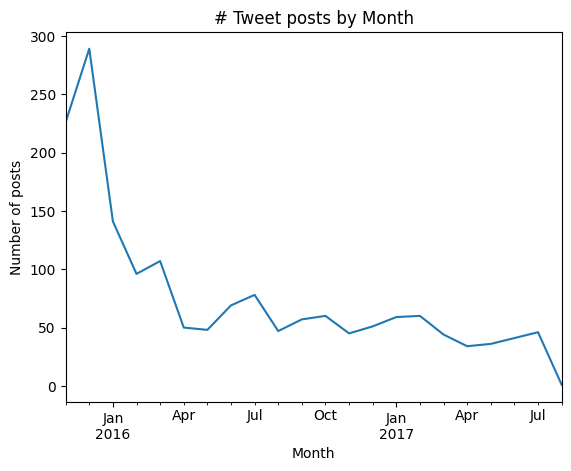

In [2388]:
monthly_tweet_counts.plot()
plt.title('# Tweet posts by Month')
plt.xlabel('Month')
plt.ylabel('Number of posts')

=> **The number of posts of this account has significantly decreased since the account was first started**

### Question 2: What is the monthly trend of interactions with We Rate Dogs' posts?

I define "interactions" = total retweets + favorites.

In [2389]:
# Create new columns to sum the total interactions
archive_clean['interactions'] = archive_clean['retweet_count'] + archive_clean['favorite_count']

# Same as question 1, count -> mean
monthly_interaction_mean = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['interactions'].mean()

/var/folders/vd/qsmzl1mx1p501xhk4zp5x8x40000gn/T/ipykernel_65976/2966691573.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_interaction_mean = archive_clean.groupby(archive_clean['timestamp'].dt.to_period('M'))['interactions'].mean()


Text(0, 0.5, 'Interactions')

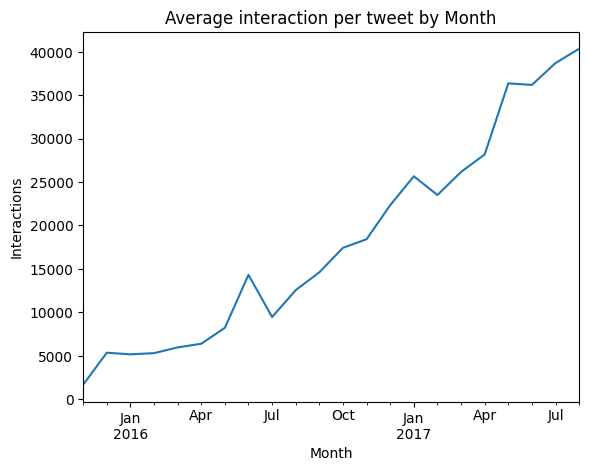

In [2390]:
monthly_interaction_mean.plot()
plt.title('Average interaction per tweet by Month')
plt.xlabel('Month')
plt.ylabel('Interactions')

=> **The interaction with WeRateDogs' posts has increased 7 times since the account was started**

### Question 3: What are the most popular dog breeds based on (1) number of posts, (2) interactions by Twitter users, and (3) ratings?

(1) Number of tweets

Text(0, 0.5, 'Breed')

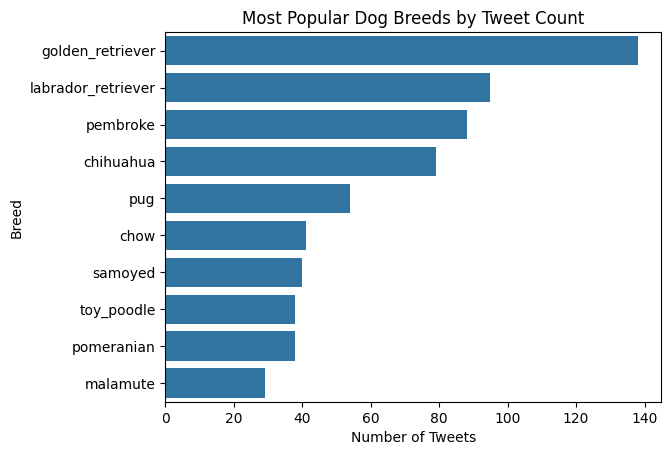

In [2391]:
top10_dog = archive_clean['breed'].value_counts().head(10)

sb.countplot(data=archive_clean, y='breed',order=top10_dog.index)
plt.title('Most Popular Dog Breeds by Tweet Count')
plt.xlabel('Number of Tweets')
plt.ylabel('Breed')


In [2392]:
archive_clean['breed'].value_counts(normalize=True).head(5)

breed
golden_retriever      0.093496
labrador_retriever    0.064363
pembroke              0.059621
chihuahua             0.053523
pug                   0.036585
Name: proportion, dtype: float64

=> **Golden retrievers are by far the most commonly rated breed, followed by labrador, pembrokes and chihuahua**

(2) Interactions

In [2393]:
archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,breed,interactions
0,892177421306343426,0,0,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,6514,33819,chihuahua,40333


Text(0, 0.5, 'Breed')

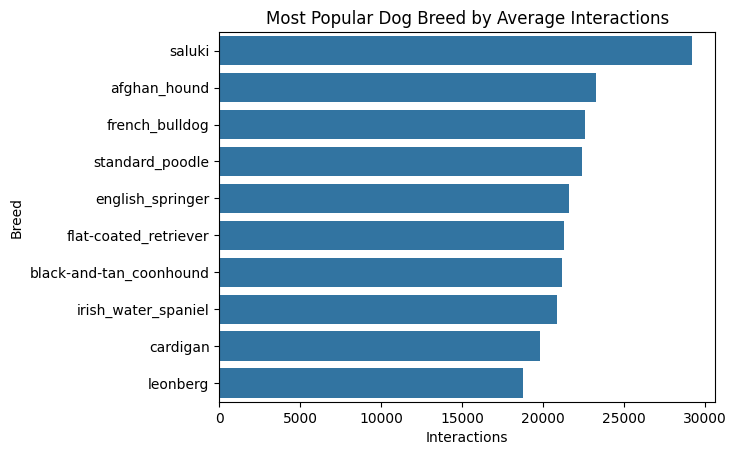

In [2394]:
top_interaction_by_breed = pd.DataFrame(archive_clean.groupby(archive_clean['breed'])['interactions'].mean().sort_values(ascending=False).head(10))
sb.barplot(data=top_interaction_by_breed,x='interactions',y='breed')
plt.title('Most Popular Dog Breed by Average Interactions')
plt.xlabel('Interactions')
plt.ylabel('Breed')

=> **Saluki, afghan hound and french bulldog are breeds that often received highest number of interactions on average**

(3) Ratings

0

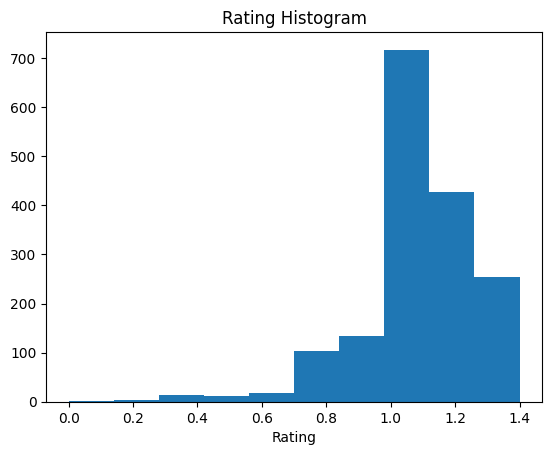

In [2395]:
# Calculate ratings, and check if there is any outlier
archive_clean['ratings'] = archive_clean['rating_numerator']/archive_clean['rating_denominator']
plt.hist(data=archive_clean,x='ratings')
plt.title('Rating Histogram')
plt.xlabel('Rating')

sum(archive_clean['ratings'] > 10)

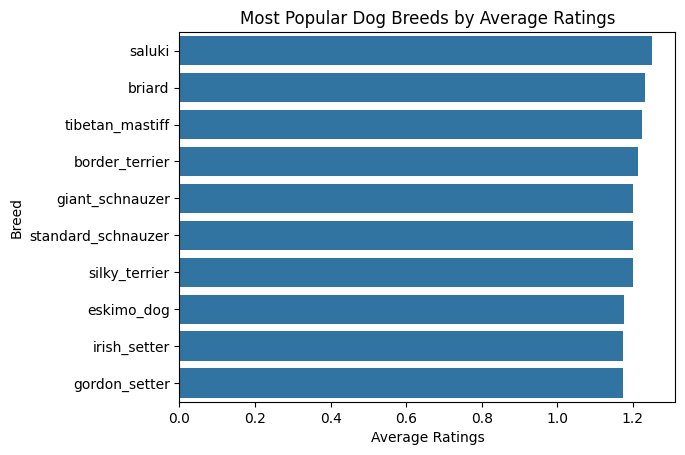

In [2396]:
# No outliers -> analyze through the same process
top_ratings_by_breed = pd.DataFrame(archive_clean.groupby('breed')['ratings'].mean().sort_values(ascending=False).head(10))
sb.barplot(data=top_ratings_by_breed,x='ratings',y='breed')
plt.title('Most Popular Dog Breeds by Average Ratings')
plt.xlabel('Average Ratings')
plt.ylabel('Breed');

=> **Not much different between the top 10 dog breeds by average ratings, which brings me to the 4th questions:**

### Question 4: Is there any correlation between ratings and interactions?

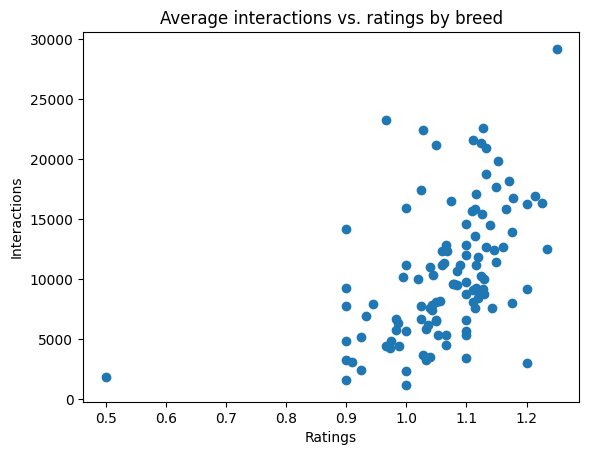

In [2397]:
# Create another df for full mean of interactions and ratings by breed
int_and_rat_by_breed = pd.DataFrame(archive_clean.groupby(archive_clean['breed'])[['interactions','ratings']].mean())

# Plot x = interactions and y = ratings on a scatterplot to see if there's any correlation
plt.scatter(int_and_rat_by_breed['ratings'],
            int_and_rat_by_breed['interactions']
            );
plt.title('Average interactions vs. ratings by breed')
plt.xlabel('Ratings')
plt.ylabel('Interactions')
plt.show()

=> **There appears to be a positive correlation between these 2 variables. I check for Pearson correlation coefficient to see how strong this correlation**

In [2398]:
pearsonr(int_and_rat_by_breed['ratings'],
            int_and_rat_by_breed['interactions'])

PearsonRResult(statistic=0.4829769526369525, pvalue=7.931961272217375e-08)

=> **r=0.48 -> the correlation is moderately positive, with the very low p-value (<<0.05) indicates that the correlation is statistically significant**

---

# 6. Conclusion

A final report can be found [here](https://github.com/linhnp511/Data-Analytics-Portfolio/blob/master/Python/Projects/Twitter%20WeRateDogs%20Data%20Set/we_rate_dogs_report.ipynb)